In [1]:
import sys
if (path := "C:/Users/Tom/pycharm-projects/python-control") not in sys.path:
    sys.path.append(path)

# Frequency Response of a Feedback System
---

In [2]:
import numpy as np
from python_control import (
    s, TransferFunction, 
    FeedbackSystem, is_second_order_approx,
    FrequencyResponse,
    ClosedLoopTransientResponse, plot_bode_diagrams,
    get_percent_overshoot,
    LineChart
)
from python_control.design import (
    create_second_order_system,
    plot_step_responses
)

## Open-Loop Transfer Function and Feedback System

In [3]:
KG = TransferFunction(50 / (s * (s + 3) * (s + 6)))
KG.expr

50.0/(1.0*s**3 + 9.0*s**2 + 18.0*s)

In [4]:
fbsys = FeedbackSystem(KG)
fbsys.closed_loop.expr

50.0/(1.0*s**3 + 9.0*s**2 + 18.0*s + 50.0)

In [5]:
print(
    f"Feedback system can be approximated as second-order? "
    f"{is_second_order_approx(fbsys)}"
)

Feedback system can be approximated as second-order? True


In [6]:
sosys = create_second_order_system(
    dominant_pole=fbsys.dominant_pole_pair[0],
    dc_gain=fbsys.closed_loop.dc_gain
)

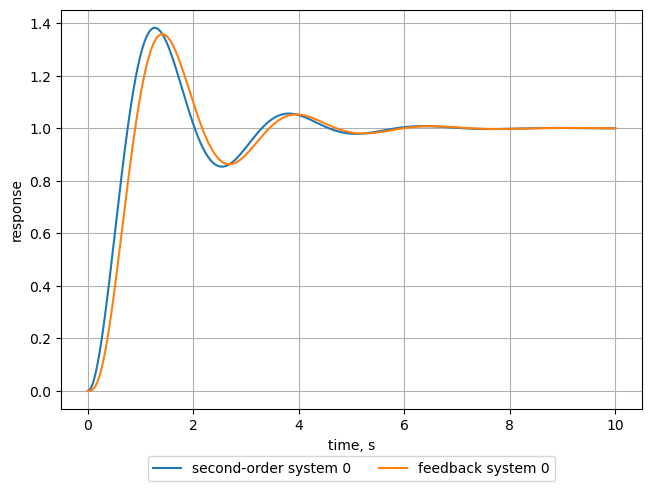

In [7]:
plot_step_responses(fbsys, sosys)

## Open-Loop Frequency Response

In [8]:
G_jw = FrequencyResponse(KG)
G_jw.expr

50.0/(-1.0*I*omega**3 - 9.0*omega**2 + 18.0*I*omega)

In [9]:
K_MS, omega_MS = G_jw.marginal_stability_gain
print(
    f"The feedback system with open-loop gain K={K_MS:.3f} "
    f"will become marginally stable @ {omega_MS:.3f} rad/s."
)
K_SR = G_jw.stability_gain_range
print(
    f"The feedback system is stable for open-loop gains "
    f"between {K_SR[0]:.3f} and {K_SR[1]:.3f}"
)

The feedback system with open-loop gain K=162.000 will become marginally stable @ 4.243 rad/s.
The feedback system is stable for open-loop gains between 0.000 and 162.000


## Closed-Loop Frequency Response

In [10]:
T_jw = FrequencyResponse(fbsys.closed_loop)
T_jw.expr

50.0/(-1.0*I*omega**3 - 9.0*omega**2 + 18.0*I*omega + 50.0)

## Polar Plot of Open-Loop and Closed-Loop Frequency Response

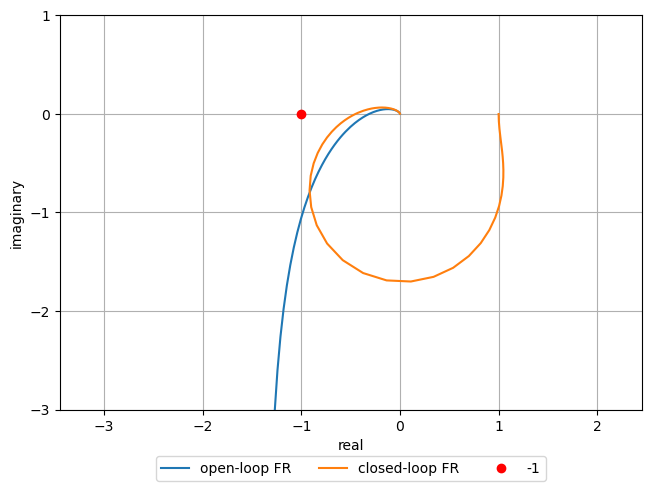

In [11]:
# Range of angular frequencies.
omega_values = np.linspace(0.01, 100, 1000)

# Values of the open-loop frequency response.
G_jw_values = G_jw(omega_values)

# Values of the closed-loop frequency response.
T_jw_values = T_jw(omega_values)

# Draw the plot in the complex plane.
chart1 = LineChart()
chart1.add_xy_data(
    label='open-loop FR',
    x1_values=G_jw_values.real,
    y1_values=G_jw_values.imag
)
chart1.add_xy_data(
    label='closed-loop FR',
    x1_values=T_jw_values.real,
    y1_values=T_jw_values.imag
)
chart1.add_xy_data(
    label='-1',
    x1_values=[-1],
    y1_values=[0],
    style_props={'marker': 'o', 'color': 'red', 'linestyle': 'none'}
)
chart1.x1.axes.axis('equal')
chart1.x1.scale(-3, 2, 1)
chart1.y1.scale(-3, 1, 1)
chart1.x1.add_title('real')
chart1.y1.add_title('imaginary')
chart1.add_legend(columns=3)
chart1.show()

## Gain Margin

In [12]:
GM, omega_GM = G_jw.gain_margin()
print(
    f"With open-loop gain {KG.gain} the feedback system "
    f"has a gain margin of {GM:.3f} dB.\n"
    f"The phase angle of the open-loop transfer function "
    f"becomes 180° @ {omega_GM:.3f} rad/s."
)

With open-loop gain 50.0 the feedback system has a gain margin of 10.211 dB.
The phase angle of the open-loop transfer function becomes 180° @ 4.243 rad/s.


## Phase Margin

In [13]:
PM, omega_PM = G_jw.phase_margin()
print(
    f"With open-loop gain {KG.gain} the feedback system "
    f"has a phase margin of {PM:.3f}°.\n"
    f"The magnitude of the open-loop transfer function "
    f"becomes 1 @ {omega_PM:.3f} rad/s."
)

With open-loop gain 50.0 the feedback system has a phase margin of 35.015°.
The magnitude of the open-loop transfer function becomes 1 @ 2.133 rad/s.


## Bode Plot of Open-Loop Frequency Response

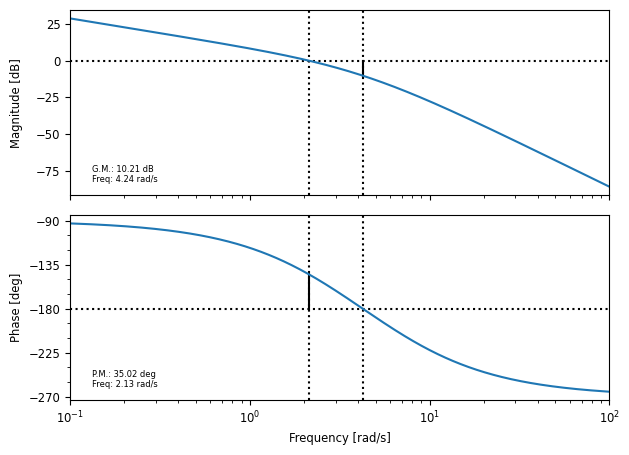

In [14]:
G_jw.bode_plot(display_margins='overlay', wrap_phase=False)

## Peak Magnitude and Bandwidth Frequency of Closed-Loop Frequency Response

In [15]:
M_pk, omega_pk = T_jw.get_peak_magnitude(omega_limits=(0.01, 10))
omega_bdw, M_bdw = T_jw.get_bandwidth_frequency()
M_pk_dB = 20 * np.log10(M_pk)

print(
    f"The feedback system with closed-loop gain {fbsys.closed_loop.gain:.3f} "
    f"reaches its peak magnitude {M_pk:.3f} @ {omega_pk:.3f} rad/s."
)
print(
    f"The bandwidth frequency lies at {omega_bdw:.3f} rad/s."
)

The feedback system with closed-loop gain 50.000 reaches its peak magnitude 1.706 @ 2.328 rad/s.
The bandwidth frequency lies at 3.627 rad/s.


### Magnitude of Closed-Loop Frequency Response versus Frequency Plot

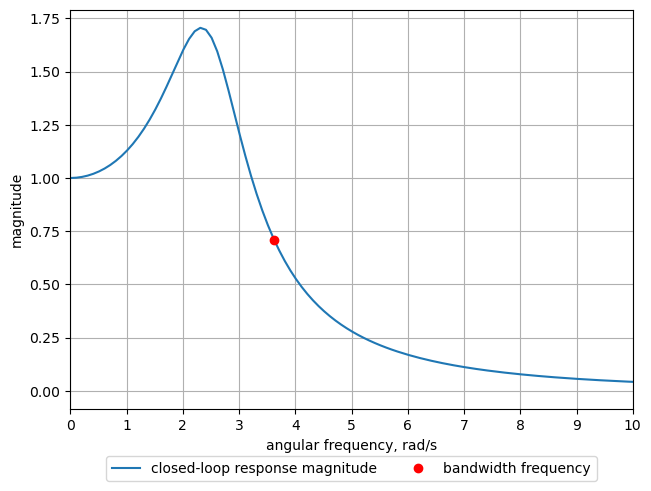

In [16]:
T_jw_magnitudes = np.abs(T_jw_values)

chart2 = LineChart()
chart2.add_xy_data(
    label='closed-loop response magnitude',
    x1_values=omega_values,
    y1_values=T_jw_magnitudes
)
chart2.add_xy_data(
    label='bandwidth frequency',
    x1_values=[omega_bdw],
    y1_values=[M_bdw],
    style_props={'marker': 'o', 'color': 'red', 'linestyle': 'none'}
)
chart2.x1.add_title('angular frequency, rad/s')
chart2.x1.scale(0, 10, 1)
chart2.y1.add_title('magnitude')
chart2.add_legend()
chart2.show()

## Transient Response Characteristics from Closed-Loop Frequency Response

Knowing the peak magnitude and the peak frequency of the closed-loop frequency response of the feedback system, the transient response characteristics of the feedback system can be estimated on condition that the closed-loop transfer function approximates the transfer function of a second-order system.

In [17]:
transient_resp = ClosedLoopTransientResponse.solve(M_p=M_pk, omega_p=omega_pk)
print(
    "Transient response characteristics of feedback system:",
    f"- damping ratio = {transient_resp.zeta:.3f}",
    f"- natural frequency = {transient_resp.omega_nat:.3f} rad/s",
    f"- percent overshoot = {get_percent_overshoot(transient_resp.zeta):.3f} %",
    f"- settling time = {transient_resp.T_s:.3f} s",
    f"- peak time = {transient_resp.T_p:.3f} s",
    sep='\n'
)

Transient response characteristics of feedback system:
- damping ratio = 0.308
- natural frequency = 2.587 rad/s
- percent overshoot = 36.150 %
- settling time = 5.019 s
- peak time = 1.277 s


Compare with the second-order system:

In [18]:
print(
    f"- damping ratio of the second-order system = {sosys.damping_ratio:.3f}",
    f"- natural frequency of the second-order system = {sosys.natural_frequency:.3f} rad/s",
    f"- percent overshoot of the second-order system = {sosys.percent_overshoot:.3f} %",
    f"- settling time of the second-order system = {sosys.settling_time:.3f} s",
    f"- peak time of the second-order system = {sosys.peak_time:.3f} s",
    sep='\n'
)

- damping ratio of the second-order system = 0.293
- natural frequency of the second-order system = 2.584 rad/s
- percent overshoot of the second-order system = 38.242 %
- settling time of the second-order system = 5.233 s
- peak time of the second-order system = 1.271 s


Compare with the methods of `FeedbackSystem` (that don't use the analytic formulas of a second-order system, but are based on the basic definitions):

In [19]:
print(
    f"- percent overshoot of the feedback system = {fbsys.percent_overshoot():.3f} %",
    f"- settling time of the feedback system = {fbsys.settling_time():.3f} s",
    f"- peak time of the feedback system = {fbsys.peak_time():.3f} s",
    sep='\n'
)

- percent overshoot of the feedback system = 35.856 %
- settling time of the feedback system = 4.557 s
- peak time of the feedback system = 1.412 s
